In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import re
import time
import copy as cp
import argparse
import toml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import pandas as pd
import zeus

from scipy.interpolate import PchipInterpolator, CubicSpline

import alfred.utils as utils
import alfred.emulator as emulator
import alfred.KSZ as KSZ
import alfred.peefit as peefit
import alfred.surveys as surveys

import joblib
import keras
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import warnings
from types import SimpleNamespace
from scipy.interpolate import RegularGridInterpolator, RectBivariateSpline
from catwoman.shelter import Cat

import alfred.surveys as surveys
import alfred.emulator as emulator
import alfred.utils as utils
from alfred.parameters import *
from alfred.astrofit import *

2025-10-23 15:07:32.523536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761224852.582385  750496 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761224852.595682  750496 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761224852.630074  750496 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761224852.630104  750496 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761224852.630108  750496 computation_placer.cc:177] computation placer alr

parsing /data/cluster/emc-brid/Datasets/LoReLi/spectra/kSZ/LoReLi/nells30_v5 ...
6797 sims available
Now on 0 run...
Now on 1 run...
Now on 2 run...
Now on 3 run...
Now on 4 run...


In [4]:
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for rendering
    'font.size': 13,
   "font.family": "serif",  # Use serif font
   "font.serif": ["Computer Modern Roman"],  # LaTeX's default font
})

# Introduction to LoReLi

$\textit{This notebook walks you through accessing the LoReLi database, from parsing the simulation metadata to loading data products, such as simulation field cubes or spectra.}$

The LoReLi II database is a set of ~10000 simulations of neutral hydrogen designed to study the evolution of the intergalactic medium (IGM) during the Epoch of Reionisation (EOR). At a series of redshift slice, it says a variety of simulated fields as outputs, which can be used for a variety of purposes. For some typical science cases, some useful fields might be: density ($\texttt{density}$), 21cm brightness temperature ($\texttt{tdb}$), or the ionisation field ($\texttt{xion}$). 

(See arXiv:2310.02684 and arXiv:2411.03093 for more information)

### Accessing the database metadata.

Each unique LoReLi simulation was run with a different set of astrophysical parameters. These parameters, and the associated simulation number, can be accessed from the database: 

In [5]:
# Note that the X-ray efficiency, fX, and the minimum halo mass, Mmin, values are logged
df

,fX,rHS,tau,Mmin,fesc
sim_n,,,,,
12104,-1.716699,0.8,3.186730,9.33,0.275
10630,-3.540608,0.0,3.487252,8.27,0.275
14596,-1.716699,0.0,3.601125,8.53,0.050
18223,-2.884190,0.6,3.697386,8.00,0.500
12090,-2.050181,0.4,3.186730,9.33,0.275
...,...,...,...,...,...
17154,-2.217012,0.4,3.589380,8.00,0.500
11452,-2.384260,0.0,3.396862,9.07,0.275
11425,-3.211549,0.6,3.396862,9.07,0.275


How many unique values of the minimum halo mass are we working with here?

In [6]:
df['Mmin'].value_counts()

Mmin
9.07    1113
8.53    1078
8.27    1033
8.80    1032
9.33     971
8.00     926
9.60     644
Name: count, dtype: int64

### Accessing field level data

The simulation cubes themselves are large arrays with $\texttt{shape=(n of redshifts, 256,256,256)}$, and so should only be loaded if you really want to use them. Loading on a computing cluster is fortement conseillez as they will crash your laptop (although you can get away with it for a little bit).

Due to their large size, not all LoReLi simulation cubes are available on $\texttt{glx}$. The currently available simulations are:

simu10038,  simu10501,  simu11557,  simu12091,  simu16382,  simu16995,  simu17338,  simu18886


In [7]:
sims_with_cubes = ['10038',  '10501',  '11557',  '12091',  '16382',  '16995',  '17338',  '18886']

In [8]:
for sn in sims_with_cubes:
    print()
    print(df.loc[sn])


fX     -2.716699
rHS     0.400000
tau     3.913385
Mmin    8.000000
fesc    0.275000
Name: 10038, dtype: float64

fX     -2.884190
rHS     0.600000
tau     3.300617
Mmin    9.600000
fesc    0.275000
Name: 10501, dtype: float64

fX     -1.716699
rHS     0.600000
tau     3.294731
Mmin    9.330000
fesc    0.275000
Name: 11557, dtype: float64

fX     -2.050181
rHS     0.600000
tau     3.186730
Mmin    9.330000
fesc    0.275000
Name: 12091, dtype: float64

fX     -2.050181
rHS     0.800000
tau     3.072875
Mmin    9.070000
fesc    0.050000
Name: 16382, dtype: float64

fX     -2.384260
rHS     1.000000
tau     3.402743
Mmin    9.330000
fesc    0.500000
Name: 16995, dtype: float64

fX     -3.540608
rHS     0.000000
tau     3.283007
Mmin    8.800000
fesc    0.500000
Name: 17338, dtype: float64

fX     -1.716699
rHS     0.000000
tau     3.919256
Mmin    8.270000
fesc    0.500000
Name: 18886, dtype: float64


We can load one of the simulations and take a look. If you want every single snapshot available, you can set skip_early=False. However, the ionisation fraction tends to wobble up and down a little bit at the earliest redshifts. This is a numerical issue, and it will make interpolating over xe very annoying. Therefore, it is advised that you keep skip_early=True. Then the first index will correspond to the first index of that particular simulation where xe is monotonically increasing from that redshift onward.

In [22]:
sn = '10038'

sim = Cat(sn,
    skip_early=False,
    path_spectra='spectra',
    path_sim='/data/cluster/emc-brid/Datasets/LoReLi/simcubes',
    base_dir=base_dir,
    load_params=False,
    load_spectra=True,
    just_Pee=True,
    reinitialise_spectra=False,
    save_spectra=False,
    load_density_cubes=True,
    load_xion_cubes=False,
    load_T21cm_cubes=False,
    verbose=True)

Loading sim number 10038...
Fetching reference files...
Fetching redshifts from:
	 /data/cluster/emc-brid/Datasets/LoReLi/metadata/redshift_list.dat
Fetching density cubes from:
	 path: /data/cluster/emc-brid/Datasets/LoReLi/simcubes/simu10038/postprocessing/cubes/xion

No ion box available, loading ionisation history from file...
Loading the follow spectra from:
	Pee: /data/cluster/emc-brid/Datasets/LoReLi/spectra/Pee/simu10038_Pee_spectra.npz

Loading precalculated spectra (from cubes). If you would like fresh spectra, rerun with reinitialise_spectra=True


Simulation 10038 loaded and ready for science!!



In [ ]:
sim.xion.shape

If load_xion_cubes=True, it was calculate the ionisation history on the fly from the fields. We can look at the ionisation history, which we calculated from the boxes.

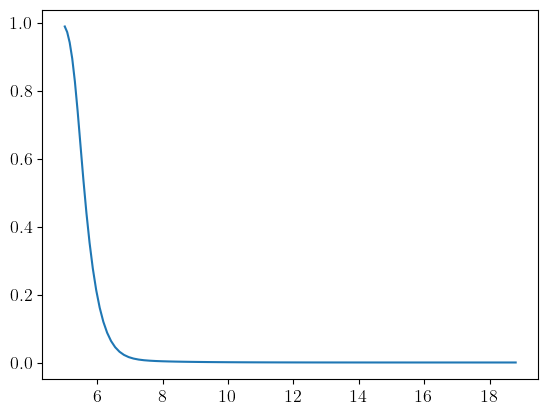

In [10]:
plt.plot(sim.z, sim.xe)

You can also use set use_LoReLi_xe=True in order to fetch the ionisation history from the saved files instead. The data files will also be used if you do not ask to load the xion cubes. Note the ionisation histories will look a little different:

In [11]:
sim_LoReLixe = Cat(sn,
    skip_early=True,
    path_sim='/data/cluster/emc-brid/Datasets/LoReLi/simcubes',
    base_dir=base_dir,
    load_spectra=False,
    use_LoReLi_xe=True,
    load_density_cubes=False,
    load_xion_cubes=False,
    load_T21cm_cubes=False,
    verbose=True)

Loading sim number 10038...
No ion box available, loading ionisation history from file...

Simulation 10038 loaded and ready for science!!



Text(0.5, 1.0, 'ratio')

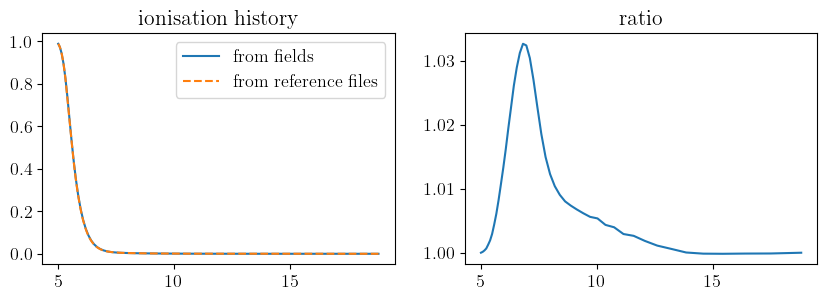

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(sim.z, sim.xe, label='from fields')
ax[0].plot(sim_LoReLixe.z, sim_LoReLixe.xe, label='from reference files', ls='--')

xe_interp = np.interp(sim.z[::-1], sim_LoReLixe.z[::-1], sim_LoReLixe.xe[::-1]) # since x needs to monotonically increasing
ax[1].plot(sim.z, sim.xe / xe_interp[::-1])

ax[0].legend()

ax[0].set_title('ionisation history')
ax[1].set_title('ratio')

It is unlikely for you to need this, but you can set load_params=True and then you have access to the metadata of that particular simulation run.

In [13]:
sim.params

{'debug': 'F ',
 'restart': 'F ',
 'restart_N': '11 ',
 't_final': '94.5 ',
 'box_size': '296735.90504451 ',
 'sortie': '3 ',
 'diagnosis_n': '1 ',
 'collisions': '1 ',
 'boundary_condition': 'periodic ',
 'dtime': '0.7 ',
 'theta': '0.7 ',
 'eps': '70 ',
 'use_quad': 'T ',
 'use_cosmo': 'T ',
 'use_cooling': 'T ',
 'use_sticky': 'F ',
 'UO': '0.01 ',
 'ncrit': '15 ',
 'just_radiative': 'F ',
 'use_quasar': 'T ',
 'only_dynamic': 'F ',
 'UV_RT_dynamic_use': 'T ',
 'use_Helium': 'F ',
 'LyA_from_Xray': 'F ',
 'save_lightcones': 'T ',
 'elasticity_params': '(0.999996, 1.) ',
 'ion_escapefrac': '0.003 ',
 'Xray_Lfunc': '0.00192 ',
 'overdensity_thresh': '100. ',
 'gasconversion_timescale': '8191.9 ',
 'feedback_efficiency': '0. ',
 'hard_Xray_fraction': '0.4 ',
 'log10_Mmin': '8.0 ',
 'ion_escapefrac_thresh': '0.03 ',
 'ion_escapefrac_post': '0.275 '}

 In practice, you will likely just want the values of the astrophysical parameters, which you can access from the pandas DataFrame:

In [16]:
astro_params = df.loc[sn].to_dict()
astro_params

{'fX': -2.7166987712964503,
 'rHS': 0.4,
 'tau': 3.9133846421530856,
 'Mmin': 8.0,
 'fesc': 0.275}

### Accessing field level data

In [25]:
sim.density.shape, sim.z.shape

((49, 256, 256, 256), (48,))

IndexError: index 48 is out of bounds for axis 0 with size 48

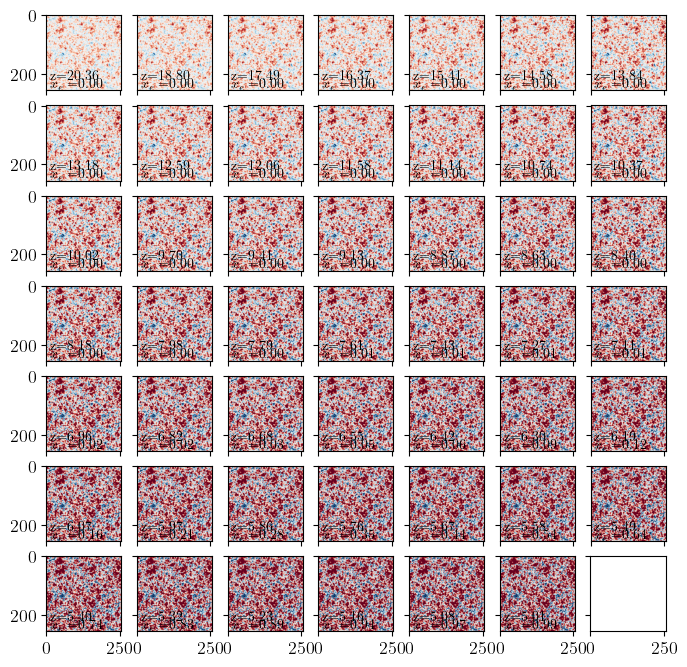

In [26]:
fig, ax = plt.subplots(7,7, sharex=True, sharey=True, figsize=(8,8))
ax = ax.flatten()

norm = matplotlib.cm.colors.TwoSlopeNorm(vcenter=0)
for i, field in enumerate(sim.density):
    delta = field / np.mean(field) - 1.0

    vmin = 0
    vmax = 0
    if delta.max() > vmax:
        vmax = delta.max()
    if delta.min() < vmin:
        vmin = delta.min()

    ax[i].annotate(f"z={sim.z[i]:.2f}", (0.05,.15), xycoords='axes fraction', fontsize=10, color='black')
    ax[i].annotate(rf"$x_e=${sim.xe[i]:.2f}", (0.05,.03), xycoords='axes fraction', fontsize=10, color='black')
    
    cbar = ax[i].imshow(delta[0], cmap='RdBu', norm=norm)
    
# cbar = fig.colorbar(cbar, ax=ax[-1])

fig.suptitle('Baryon (over)Density Field', fontsize=12)
fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(top=0.95)

In [ ]:
fig, ax = plt.subplots(7,7, sharex=True, sharey=True, figsize=(8,8))
ax = ax.flatten()

for i, field in enumerate(sim.xion):    
    ax[i].annotate(f"z={sim.z[i]:.2f}", (0.05,.15), xycoords='axes fraction', fontsize=10, color='deeppink')
    ax[i].annotate(rf"$x_e=${sim.xe[i]:.2f}", (0.05,.03), xycoords='axes fraction', fontsize=10, color='deeppink')

    ax[i].imshow(field[0], vmin=0.0, vmax=1.0)

fig.suptitle('Ionisation Field', fontsize=12)
fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(top=.95)

In [ ]:
fig, ax = plt.subplots(7,7, sharex=True, sharey=True, figsize=(8,8))
ax = ax.flatten()

for i, field in enumerate(sim.T21cm):    
    ax[i].annotate(f"z={sim.z[i]:.2f}", (0.05,.15), xycoords='axes fraction', fontsize=10, color='deeppink')
    ax[i].annotate(rf"$x_e=${sim.xe[i]:.2f}", (0.05,.03), xycoords='axes fraction', fontsize=10, color='deeppink')

    ax[i].imshow(field[0], vmin=0.0, vmax=1.0, cmap='plasma')

fig.suptitle('21cm Brightness Temperature', fontsize=12)
fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(top=.95)

Since there is only certain snapshots in redshift, sometimes you want a snapshot closest to some values:

In [27]:
index_xe50 = sim.find_z(.5)
z_xe50 = sim.z[index_xe50]

print(f'xe={sim.xe[index_xe50]} at z={z_xe50}')

xe=0.5378143510387805 at z=5.575007


In [ ]:
# index_z10 = sim.find_xe(10)
# xe_z10 = sim.xe[index_z10]

# print(f'xe={xe_z10} at z={sim.z[index_z10]}')

In [ ]:
# fig, ax = plt.subplots(7,7, sharex=True, sharey=True, figsize=(8,8))

# ax = ax.flatten()

# for i, P in enumerate(sim.Pee):
#     #xe_ind = np.abs(z - ion_histories[sim_n]['z']).argmin() 
#     z = sim.z[i]
#     xe = sim.xe[i]
#     # pbb = sim.Pbb[i]

#     ax[i].annotate(f"z={z:.2f}", (0.05,.15), xycoords='axes fraction', fontsize=9)
#     ax[i].annotate(rf"$x_e=${xe:.2f}", (0.05,.03), xycoords='axes fraction', fontsize=9)

#     lsim, = ax[i].loglog(sim.k, P, label=f'z={z}', color='green') #, yerr=np.abs(obs_errors)[i],)
#   #  lbb, = ax[i].loglog(k, pbb, color=palette[0], alpha=1.0, lw=.75)
#     ldd, = ax[i].loglog(sim.k, model.Pdd[i], color='black', ls='--', alpha=.5, lw=.65)
# #    lpee, = ax[i].loglog(k, model.spectra[i], color=palette[1], ls='--', alpha=.5, lw=.65)
# #    lcamb_bb, = ax[i].loglog(sim.k, PK_bb.P(z,k), color='red')

# custom_handles = [
#     Line2D([], [], color=ldd.get_color(), linestyle=ldd.get_linestyle(), label='dark matter from CAMB'),
# #    Line2D([], [], color=lbb.get_color(), linestyle=lbb.get_linestyle(), label='baryon power spectrum'),
#     Line2D([], [], color=lsim.get_color(), linestyle=lsim.get_linestyle(), label='electron power spectrum'),
# ]

# ax[-1].legend(handles=custom_handles)
# ax[0].set_xlim(sim.k[0], sim.k[-2])

# fig.supxlabel('k')
# # fig.supylabel('Power')

# fig.subplots_adjust(wspace=0, hspace=0)
# fig.suptitle('Spectra', fontsize=12)
# fig.subplots_adjust(top=0.95)

### Accessing power spectrum level data

In addition to the simulation cubes themselves, one can access various power spectra of roughly ~7000 of the LoReLi simulations. These can be fetched via the helper function in utils:

Text(0, 0.5, '$P_{ee}(k)$ [$(\\mathrm{Mpc}/h)^3$]')

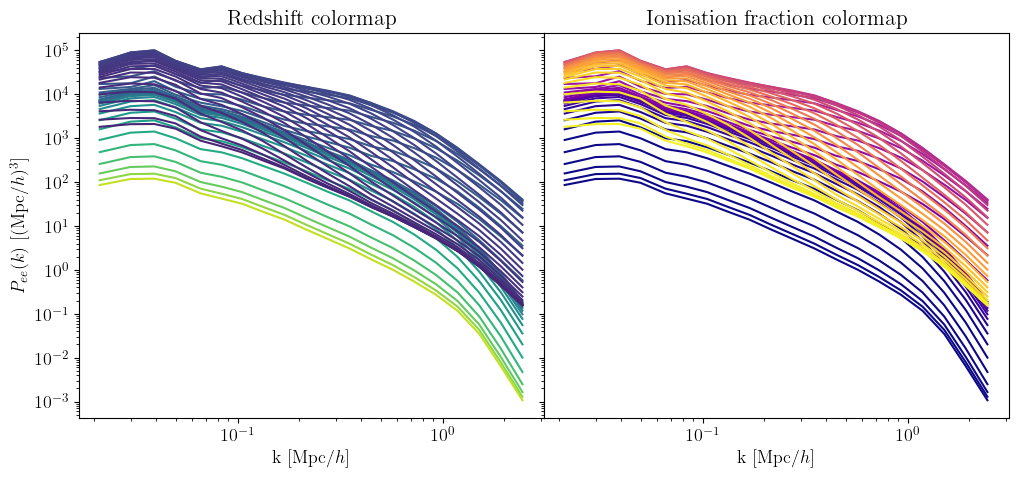

In [28]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,5))
fig.subplots_adjust(wspace=0.0)

for i, z in enumerate(sim.z):
    ax[0].loglog(sim.k, sim.Pee[i], color=cmap_z(norm_z(z)))

for i, xe in enumerate(sim.xe):
    ax[1].loglog(sim.k, sim.Pee[i], color=cmap_xe(norm_xe(xe)))

ax[0].set_title('Redshift colormap')
ax[1].set_title('Ionisation fraction colormap')

[a.set_xlabel(r"k [Mpc/$h$]") for a in ax]
ax[0].set_ylabel(r"$P_{ee}(k)$ [$(\mathrm{Mpc}/h)^3$]")

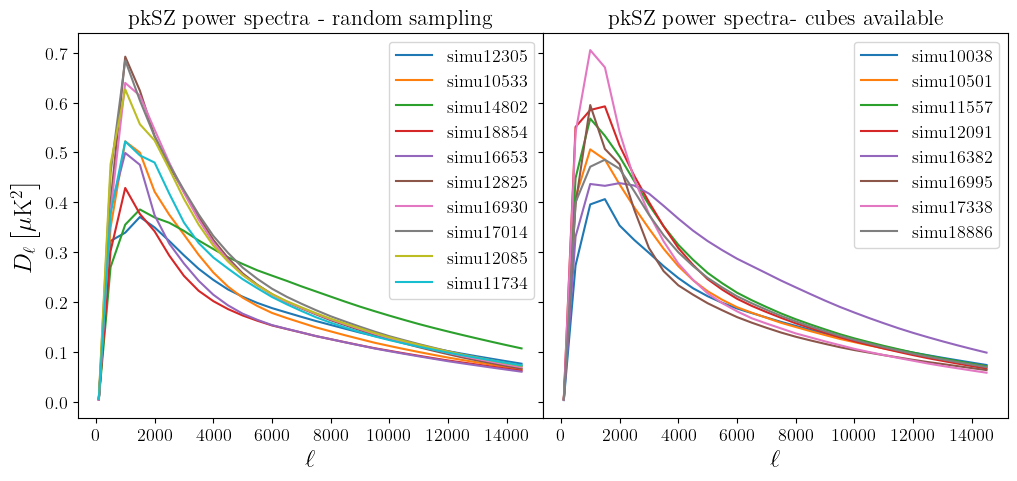

In [29]:
sn_sample = df.sample(n=10).index

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,5))
fig.subplots_adjust(wspace=0.0)

for sn in sn_sample:
    ax[0].plot(ells, utils.spectra(sn), label=f"simu{sn}")

for sn in sims_with_cubes:
    ax[1].plot(ells, utils.spectra(sn), label=f"simu{sn}")

[a.set_xlabel(r"$\ell$", fontsize=18) for a in ax]
ax[0].set_ylabel(r'$D_\ell \left[\mathrm{\mu K^2} \right]$', fontsize=18)

ax[0].set_title('pkSZ power spectra - random sampling')
ax[0].legend()

ax[1].set_title('pkSZ power spectra- cubes available')
ax[1].legend()

Alternatively, they be loaded using the Cat class, with load_spectra=True. If you want to reinitialise the spectra for whatever reason, you can run with reinitialise_spectra=True:

In [ ]:
sim = Cat(sn,
    skip_early=True,
    path_spectra='ps_ee',
    path_sim='/data/cluster/emc-brid/Datasets/LoReLi/simcubes',
    base_dir=base_dir,
    load_spectra=False,
    reinitialise_spectra=True,
    verbose=True)

There are two options for prefab spectra: power spectrum made using powerbox, and power spectrum run by Romain. You can specify which using the LoReLi_format flag (turn on to use Romain's spectra). Not every simulation has every saved spectra.

In [ ]:
sim_LoReLiformat = Cat(sn,
    skip_early=True,
    path_spectra='ps_ee',
    path_sim='/data/cluster/emc-brid/Datasets/LoReLi/simcubes',
    base_dir=base_dir,
    load_spectra=True,
    LoReLi_format=True,
    verbose=True)